LLM Model Test

In [1]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import getpass
import os
os.environ["HUGGINGFACE_API_KEY"] = getpass.getpass()

··········


In [13]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

import pandas as pd
# read data and put it in a dataframe
# 在 google 工作表載入 gsheets
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1mPS985ci-KtcKhUWk5yeOW_0UJL05MSAQWw4JQ6_bos/edit#gid=0')
# 從 gsheets 的工作表
sheets1 = gsheets.worksheet('text').get_all_values()

df = pd.DataFrame(sheets1[1:], columns=sheets1[0])

In [14]:
df.head()

,Name,Comment
0,Yue Zhen Li,份量還可以，口味也算不錯，青醬味沒有到特別濃厚，偏鹹但還可以。咖喱不推薦。但有多種混合的口味。 …
1,Design Danny,店內走道有些狹窄，座位前後也稍嫌擁擠些，餐點選擇多元化且出餐速度頗快，服務態度算不錯，簡單自...
2,攝影 李建鴻,我不吃肉 老闆特地做一奶油蔬菜義大利麵奶油香 麵感好 服務親切 …
3,Bibi,不是用噴槍燒一燒就叫做焗烤耶，你們只烤到表面，裡面起司都還根根分明，全部都硬塊，這怎麼吃？反...
4,W,用熊貓外送點了外帶自取，餐點特別備註要加中辣，也特別致電到店家詢問 是否可以加辣 店家女店員...


In [15]:
import re
# 只保留中文字
def keep_chinese_chars(text):
    pattern = re.compile(r'[^\u4e00-\u9fff]')
    chinese_text = re.sub(pattern, '', text)
    chinese_text = chinese_text.replace("推推", "")
    return chinese_text

In [17]:
text = df['Comment'][0]
text = keep_chinese_chars(text)
text

'份量還可以口味也算不錯青醬味沒有到特別濃厚偏鹹但還可以咖喱不推薦但有多種混合的口味'

In [18]:
from transformers import AutoModelForCausalLM, AutoTokenizer

def Mistral_summarize(text):

  device = "cuda" # the device to load the model onto

  model = AutoModelForCausalLM.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")
  tokenizer = AutoTokenizer.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")

  messages = [
      {"role": "user", "content": "What is your favourite condiment?"},
      {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
      {"role": "user", "content": {text}}
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)

  generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)
  decoded = tokenizer.batch_decode(generated_ids)

  return decoded

In [19]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import torch

def bart_summarize(text):

    keep_chinese_chars(text)

    tokenizer = BertTokenizer.from_pretrained('hfl/chinese-bert-wwm')
    model = BertForMaskedLM.from_pretrained('hfl/chinese-bert-wwm')

    inputs = tokenizer(text, return_tensors="pt", max_length=100, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=128)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [20]:
summary = bart_summarize(text)
print(summary)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


份 量 還 可 以 口 味 也 算 不 錯 青 醬 味 沒 有 到 特 別 濃 厚 偏 鹹 但 還 可 以 咖 喱 不 推 薦 但 有 多 種 混 合 的 口 味 。 湯 頭 也 是 很 好 喝 的 湯 頭 。 湯 頭 是 用 來 煮 湯 的 湯 。 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯 的 湯


In [21]:
def remove_spaces(text):
    # 使用 replace 方法來刪除空格
    return text.replace(" ", "")

output_text = remove_spaces(summary)
output_text

'份量還可以口味也算不錯青醬味沒有到特別濃厚偏鹹但還可以咖喱不推薦但有多種混合的口味。湯頭也是很好喝的湯頭。湯頭是用來煮湯的湯。湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯的湯'

In [22]:
import jieba
import jieba.analyse

jieba.analyse.extract_tags(output_text, topK=10)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.767 seconds.
DEBUG:jieba:Loading model cost 0.767 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


['湯的湯', '湯頭', '口味', '咖喱', '不錯', '青醬味', '特別', '濃厚', '但還', '推薦']

In [24]:
# 使用 jieba 提取關鍵字
def extract_keywords(text):
    #text = keep_chinese_chars(text)

    summary = bart_summarize(text)
    outputt_ext = remove_spaces(summary)

    return jieba.analyse.extract_tags(outputt_ext, topK=10)  # 提取前十個關鍵字

df['keywords'] = df['Comment'].apply(extract_keywords)

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a m

In [25]:
df.head()

,Name,Comment,keywords
0,Yue Zhen Li,份量還可以，口味也算不錯，青醬味沒有到特別濃厚，偏鹹但還可以。咖喱不推薦。但有多種混合的口味。 …,"[口味, 咖喱, 不錯, 青醬味, 特別, 濃厚, 但還, 推薦, 多種, 份量]"
1,Design Danny,店內走道有些狹窄，座位前後也稍嫌擁擠些，餐點選擇多元化且出餐速度頗快，服務態度算不錯，簡單自...,"[等等, 餐點, 感覺, 店內, 狹窄, 擁擠些, 選擇, 出餐, 服務態度, 不錯]"
2,攝影 李建鴻,我不吃肉 老闆特地做一奶油蔬菜義大利麵奶油香 麵感好 服務親切 …,"[奶油, 感好, 服務, 親切, 大利, 特地, 不吃, 蔬菜]"
3,Bibi,不是用噴槍燒一燒就叫做焗烤耶，你們只烤到表面，裡面起司都還根根分明，全部都硬塊，這怎麼吃？反...,"[這又, 是不是, 噴槍, 燒一燒, 你們, 裡面, 起司, 還根根, 硬塊, 這怎麼]"
4,W,用熊貓外送點了外帶自取，餐點特別備註要加中辣，也特別致電到店家詢問 是否可以加辣 店家女店員...,"[店家, 餐點, 特別, 詢問, 熊貓, 送點, 外帶, 致電到, 加辣, 女店員]"


In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from community import community_louvain

In [28]:
G = nx.Graph()

for index, row in df.iterrows():
    author = row['Name']
    keywords = row['keywords']

    G.add_node(author, type='Name')

    for keyword in keywords:
        G.add_node(keyword, type='keyword')
        G.add_edge(author, keyword)

In [29]:
keywords

['發現', '醬汁', '還是', '有點', '收掉', '公館', '有間', '期間', '這間', '起來']

In [30]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
from matplotlib.font_manager import fontManager
# 改style要在改font之前
# plt.style.use('seaborn')
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-05-08 19:37:57--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.196.100, 173.194.196.139, 173.194.196.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.196.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-05-08 19:37:57--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.193.132, 2607:f8b0:4001:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.193.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  38.0MB/s    in 0.5s    

2024-05-08 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


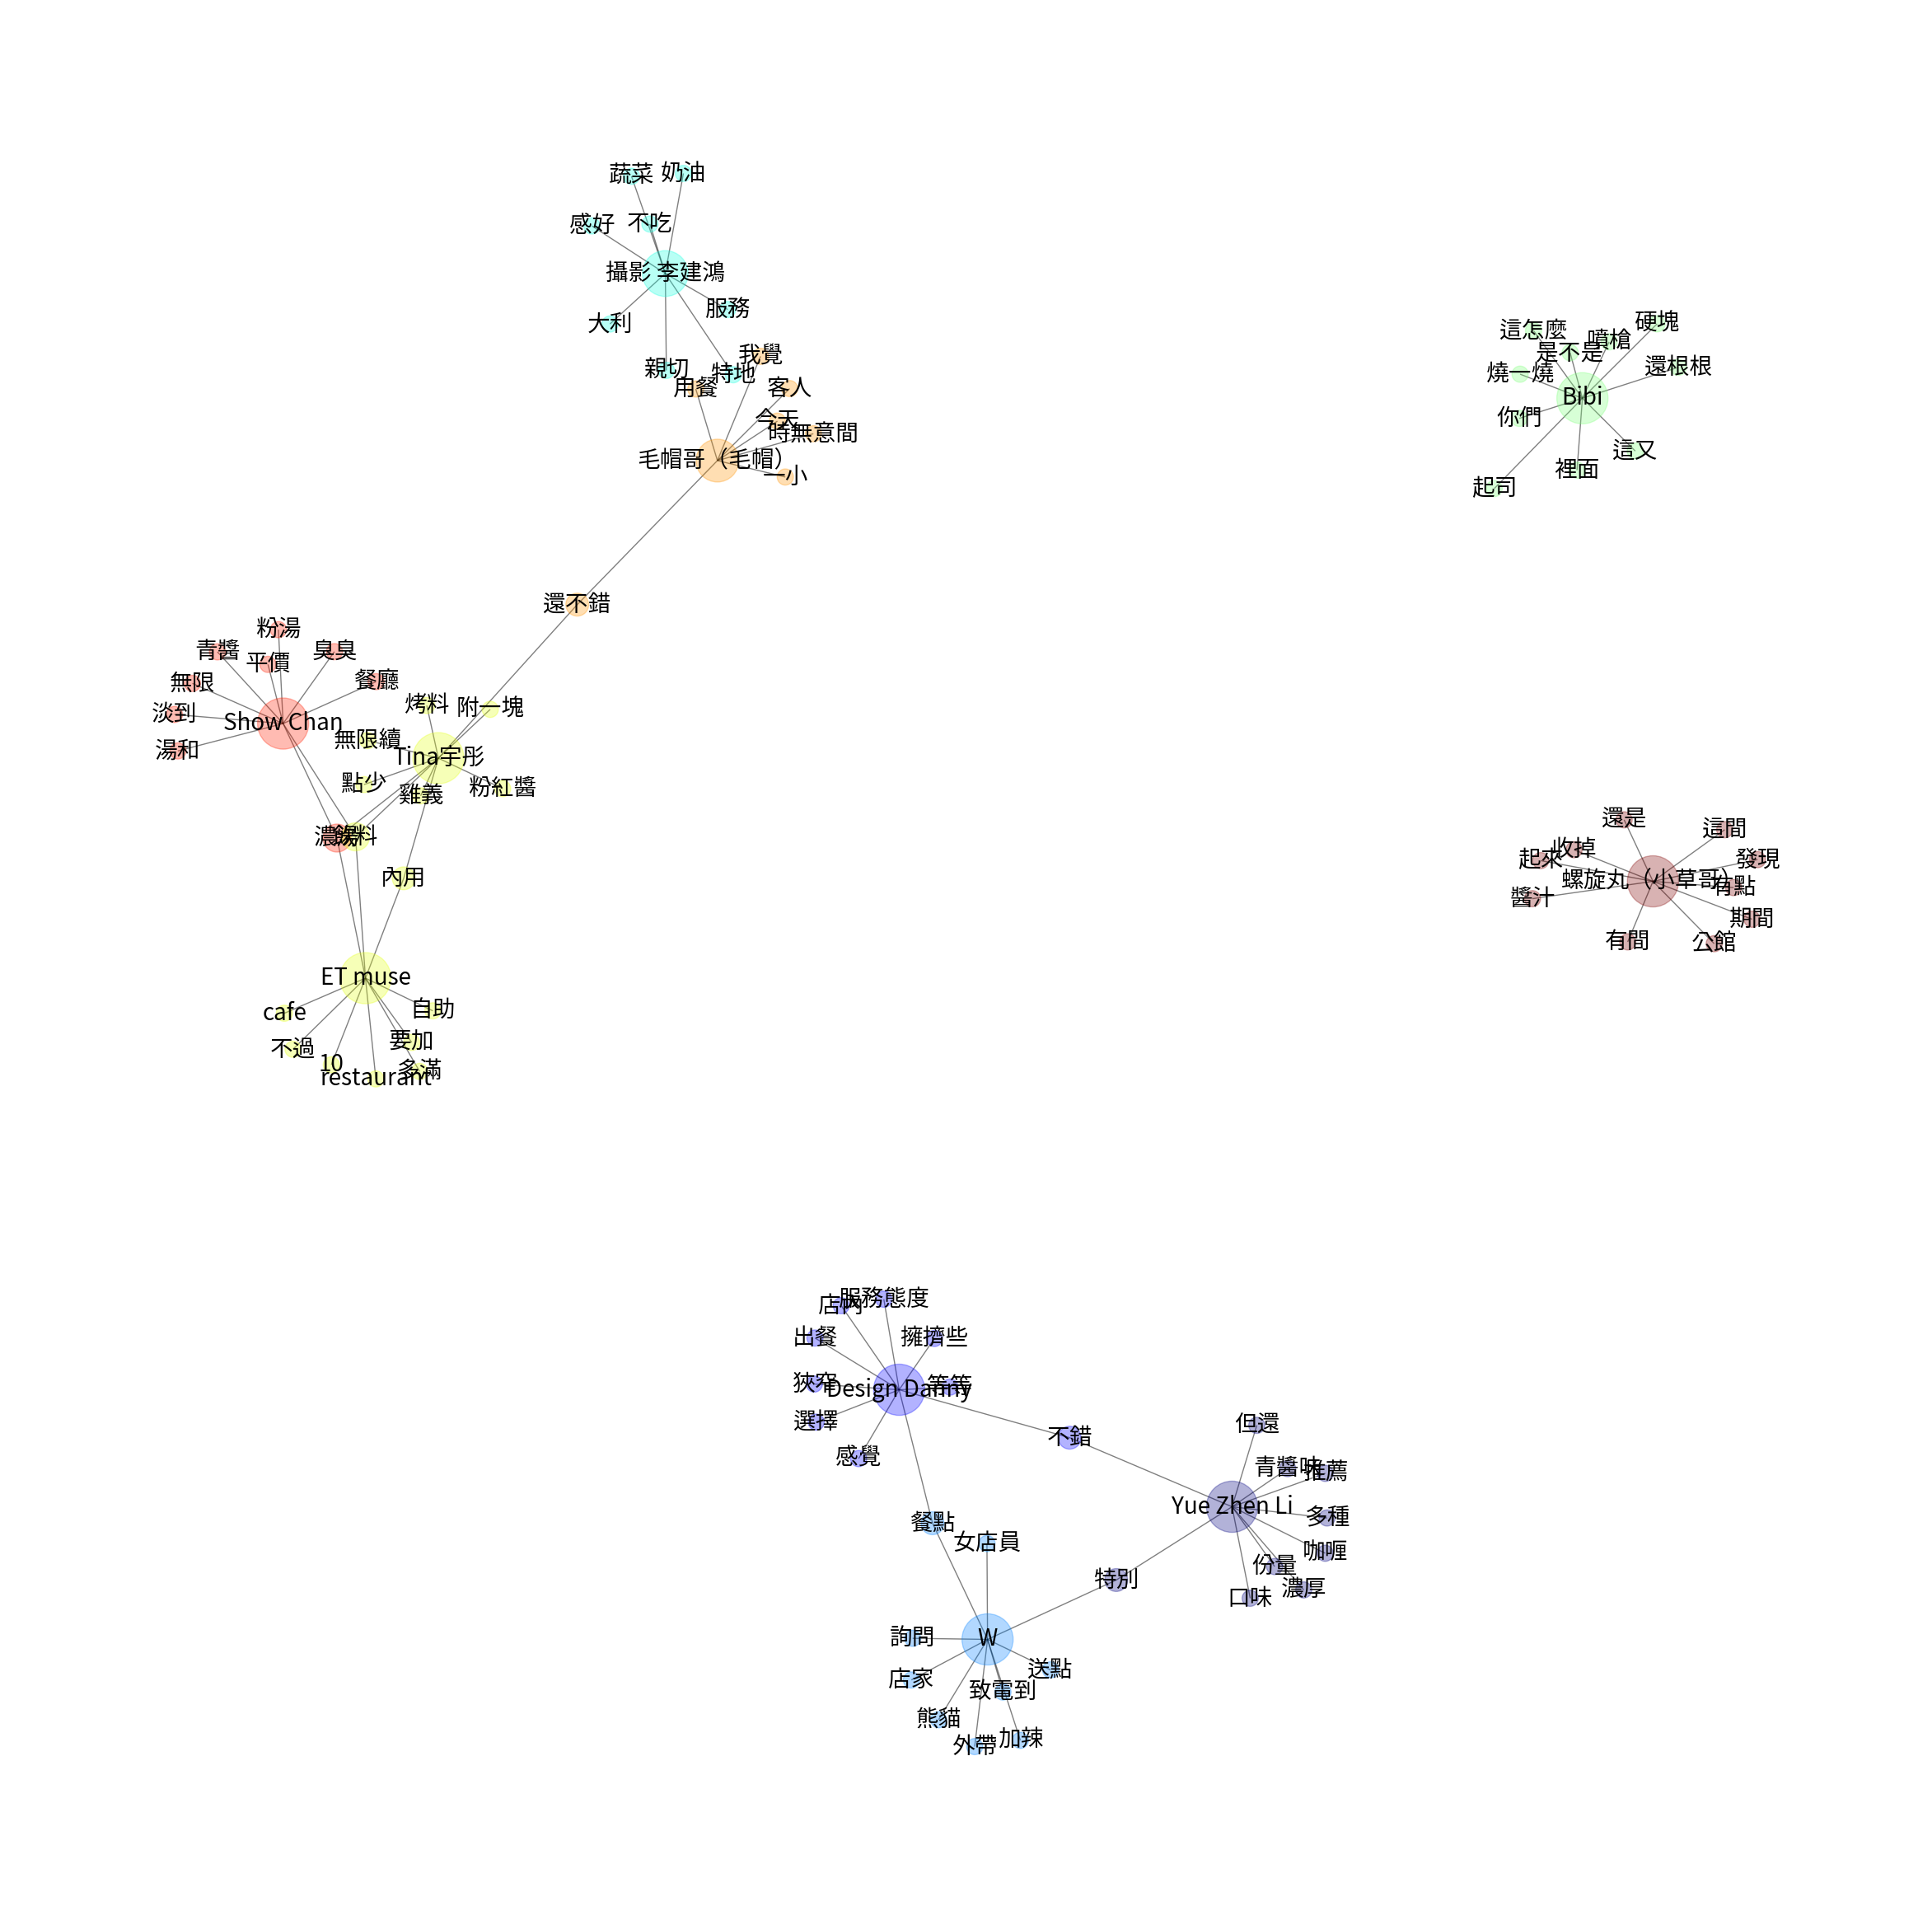

In [31]:
partition = community_louvain.best_partition(G)

community_colors = [partition[node] for node in G.nodes()]

cmap = plt.cm.jet
colors_with_alpha = [cmap(community_color / max(community_colors)) for community_color in community_colors]

colors_with_alpha = [(r, g, b, 0.3) for r, g, b, _ in colors_with_alpha]

node_sizes = [200 * G.degree(node) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.2, iterations=80)

plt.figure(figsize=(30, 30))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=colors_with_alpha, node_size=node_sizes, cmap=plt.cm.jet)
nx.draw_networkx_labels(G, pos, font_size=20, font_family='Taipei Sans TC Beta')

plt.axis('off')
plt.show()